In [45]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

tf.logging.set_verbosity(tf.logging.ERROR)

### Get data

### Normalize data

In [26]:
train_image_data = train_df.iloc[:,1:] / 255.0
train_image_labels = train_df['label']
test_image_data = test_df / 255.0

### Get train, validation and test examples

In [27]:
RATIO = 0.8

size = round(len(train_image_data) * RATIO)

# convert series to list
train_list = train_image_data.values.tolist()
test_list = test_image_data.values.tolist()

# convert lists to numpy arrays
train_examples = np.asarray(train_list[:size], dtype=np.float32)
train_labels = np.asarray(train_image_labels[:size], dtype=np.int32)

validation_examples = np.asarray(train_list[size:], dtype=np.float32)
validation_labels = np.asarray(train_image_labels[size:], dtype=np.int32)

test_examples = np.asarray(test_list, dtype=np.float32)

In [28]:
print(train_examples.shape)
print(validation_examples.shape)
print(train_labels.shape)
print(validation_labels.shape)
print(test_examples.shape)

(33600, 784)
(8400, 784)
(33600,)
(8400,)
(28000, 784)


### Input functions

In [47]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x':train_examples},
    y=train_labels,
    batch_size=80,
    num_epochs=1,
    shuffle=True)

eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x':train_examples},
    y=train_labels,
    num_epochs=1,
    shuffle=False)

valid_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x':validation_examples},
    y=validation_labels,
    batch_size=80,
    num_epochs=1,
    shuffle=True)

predict_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x':test_examples},
    num_epochs=1,
    shuffle=False)

### CNN model

In [34]:
def cnn_model_fn(features, labels, mode):
    
    reshape_layer_1 = tf.reshape(features['x'], [-1, 28, 28, 1])
    
    conv_layer_1 = tf.layers.conv2d(
        inputs=reshape_layer_1,
        filters=32,
        kernel_size=[10, 10],
        padding='same',
        activation=tf.nn.relu)
    
    conv_layer_2 = tf.layers.conv2d(
        inputs=conv_layer_1,
        filters=64,
        kernel_size=[5, 5],
        padding='same',
        activation=tf.nn.relu)
    
    reshape_layer_2 = tf.reshape(conv_layer_2, [-1, 28 * 28 * 64])
    
    dense_layer = tf.layers.dense(
        inputs=reshape_layer_2,
        units=1024,
        activation=tf.nn.relu)
    
    is_train = False
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        is_train = True
        
    dropout_layer = tf.layers.dropout(
        inputs=dense_layer,
        rate=0.4,
        training=is_train)
    
    logits_layer = tf.layers.dense(
        inputs=dropout_layer,
        units=10)
    
    predictions = {
        'classes':tf.argmax(input=logits_layer, axis=1),
        'probabilities':tf.nn.softmax(logits_layer, name='softmax_tensor')}
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    loss = tf.losses.sparse_softmax_cross_entropy(
        labels=labels,
        logits=logits_layer)
    
    accuracy = tf.metrics.accuracy(
        labels=labels,
        predictions = predictions['classes'],
        name='accu_op')
    
    tf.summary.scalar('accuracy', accuracy[1])
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        train_optimizer = tf.train.AdamOptimizer(learning_rate=LR).minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_optimizer)
    
    # mode = EVAL
    eval_metric_ops = {'accuracy':accuracy}
    
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

### Configure estimator

In [35]:
# directory to periodically save weights, biases, acc, loss
OUTDIR = './cnn_mnist_train_data'

cnn_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir=OUTDIR)

# call method to write train data to OUTDIR
#file_writer = tf.summary.FileWriter(OUTDIR)

### Train fuction

In [48]:
def train_and_evaluate(estimator, epochs=10):
    
    train_logs = []
    valid_logs = []
    
    for epoch in range(epochs):
        
        estimator.train(input_fn=training_input_fn)
        
        print('epoch {}/{}'.format(epoch + 1, epochs))
        train_log = estimator.evaluate(input_fn=eval_input_fn)
        print('train_acc:{:.3f}\ttrain_loss:{:.3f}'.format(train_log['accuracy'], train_log['loss']))
        
        valid_log = estimator.evaluate(input_fn=valid_input_fn)
        print('valid_acc:{:.3f}\tvalid_loss:{:.3f}'.format(valid_log['accuracy'], valid_log['loss']))
        
        train_logs.append(train_log)
        valid_logs.append(valid_log)
        
    return train_logs, valid_logs

### Train

In [49]:
# learning rate
LR = 0.0001

# train
train_logs, valid_logs = train_and_evaluate(cnn_classifier, epochs=5)

epoch 1/5
train_acc:0.977	train_loss:0.078
valid_acc:0.979	valid_loss:0.069
epoch 2/5
train_acc:0.986	train_loss:0.048
valid_acc:0.990	valid_loss:0.034
epoch 3/5
train_acc:0.993	train_loss:0.027
valid_acc:0.992	valid_loss:0.028
epoch 4/5
train_acc:0.992	train_loss:0.025
valid_acc:0.992	valid_loss:0.022
epoch 5/5
train_acc:0.995	train_loss:0.018
valid_acc:0.995	valid_loss:0.015


### Plot acc and loss

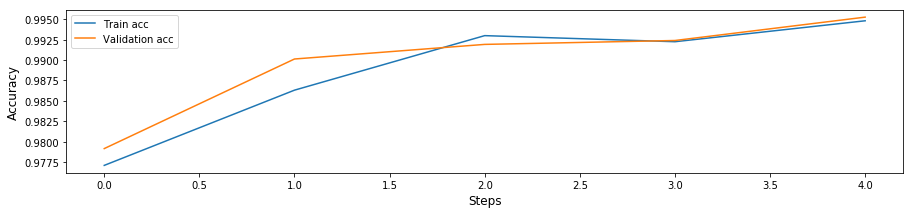

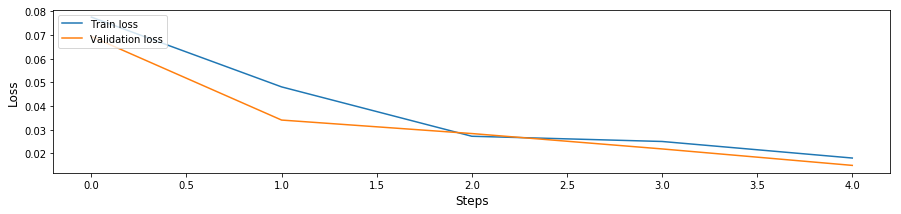

In [50]:
train_acc = [i['accuracy'] for i in train_logs]
valid_acc = [i['accuracy'] for i in valid_logs]

train_loss = [i['loss'] for i in train_logs]
valid_loss = [i['loss'] for i in valid_logs]

plt.figure(figsize=(15, 3))
plt.plot(train_acc)
plt.plot(valid_acc)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Steps', fontsize=12)
plt.legend(['Train acc', 'Validation acc'], fontsize=10, loc='upper left')
plt.show()

plt.figure(figsize=(15, 3))
plt.plot(train_loss)
plt.plot(valid_loss)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Steps', fontsize=12)
plt.legend(['Train loss', 'Validation loss'], fontsize=10, loc='upper left')
plt.show()

### Create submission file

In [51]:
# create kaggle submission file
# in predict mode model returns generator
predict_generator = cnn_classifier.predict(input_fn=predict_input_fn)

# create list of dict like {class:class, probability:probability}
predict_dictlist = [next(predict_generator) for i in range(len(test_examples))]

# for kaggle we need only classes
classes = [predict_dictlist[item]['classes'] for item in range(len(predict_dictlist))]

# function to create pandas df
def create_mnist_submission_df(class_predictions, file_name):
    submission_df = pd.DataFrame()
    submission_df['ImageId'] = range(1, 28001, 1)
    submission_df['Label'] = class_predictions
    submission_df.set_index('ImageId', inplace=True)
    submission_df.to_csv(file_name)
    print('Saved predictions to ', file_name)

create_mnist_submission_df(classes, 'submission-01.csv')

Saved predictions to  submission-01.csv
